In [1]:
# Install all important libraries
!pip install yfinance
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=ceeb3b1e1f2576895b9987cadc33ada83ee68c7cd134b9199e6a2a85a43c6c28
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [2]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


In [3]:
# For event based backtesting, an imporatant concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [4]:
class Common_Class():

  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):

    self.all_data = {}
    self.position = {}
    self.quantity = {}
    for stock in symbol:
        self.quantity['{}'.format(stock)] = 0
        self.position['{}'.format(stock)] = 0

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    # self.quantity = 0 # quantities to buy/sell
    # self.position = 0 # the trades in progress, long or short
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns=['trade','date','position','price','symbol','quantity','capital'])
    self.final_result_data = None # performance data
    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data[i] = bt_data

  def close_graph(self):
    for i in self.symbol:
      plt.figure(figsize=(15, 5))
      plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
      plt.xlabel("Days")
      plt.ylabel("Price")
      plt.title("Close Prices of {}".format(i))
      plt.legend()
      plt.grid()
      plt.show()

  def return_date_price(self, bar, stock):
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    i = str(stock)
    date = str(self.all_data[i].index[bar])[:10] #First 10 contains the date elements, rest is time
    price = self.all_data[i].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    #Returns you the realised capital in your account at a given time period / bar
    date, price = self.return_date_price(bar,self.symbol[0])
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):
    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub = ub + self.quantity['{}'.format(stock)] * price
    # print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):
    #Unrealised plus realised
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub = ub + self.quantity['{}'.format(stock)] * price
    tb = ub + self.capital
    # print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol),
                                 'quantity':pd.Series(quantity), 'capital':pd.Series(capital)})
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def performance_plots(self):
    final_result_data = self.final_result_data # save time to write self everywhere
    interval = str(self.interval)
    f, ax = plt.subplots(2,3,figsize=(20,10))

    # Plot 1: Close price as stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    # Plot 2: Histogram of strategy returns
    plt.subplot(2, 3, 2)
    plt.hist(final_result_data['Capital_Log_Returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title('Histogram of Strategy Returns')
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    # Plot 3: Strategy vs instrument
    plt.subplot(2, 3, 3)
    plt.plot(final_result_data['Total_Stock_Returns_cum_sum'], color='red', label='Equal weighted stock returns', linestyle='dashed')
    plt.plot(final_result_data['Capital_Log_Returns_cum_sum'].dropna(), label='Strategy Returns')
    plt.title('Strategy vs Stock Cum Return Curve')
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    # Plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(final_result_data['Gross_Cum_Returns'].dropna(), label='Cum Log Returns')
    plt.plot(final_result_data['Cum_Max'].dropna(), label='Max Drawdown')
    plt.title('Drawdown')
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    # Plot 5: Equity Curve
    plt.subplot(2, 3, 5)
    plt.plot(final_result_data['Capital'].dropna(), label='Equity $')
    plt.title('Equity Curve')
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2])
    plt.show()


  def performance(self):
    # Since the stocks are not stored in arranged manner, need to arrange them so that we can get the entry price and exit price for each day
    # Stored data has many rows, we will aggregate day wise
    df = pd.DataFrame() # to store aggregated values
    df['Capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    df['Capital_After_Settlement'] = df["Capital"].shift(-1) # next days capital

    trade_start_date = df['Capital'].index[0]
    trade_end_date = df['Capital'].index[-1]

    # since have multiple stocks, need to calculate expected returns to compare against the strategy
    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # returns are already log
      df['Returns_{}'.format(stock)] = A
    c = df.columns
    df['Total_Stock_Returns'] = (df.loc[:, c[-len(self.symbol):]].sum(1) / len(self.symbol)) # sums up last N columns of df and divide by number of stocks. Equal weightage.
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df['Capital_Regular_Returns'] = df['Capital_After_Settlement'] / df['Capital'] - 1
    df['Capital_Log_Returns'] = np.log(df['Capital_After_Settlement'] / df['Capital'])
    df['Capital_Log_Returns_cum_sum'] = df['Capital_Log_Returns'].cumsum()
    df.index = range(df.shape[0])

    print("-" * 50)
    print("Performance Metrics")

    # Total balance
    print("The total capital at the end of the strategy: {:0.2f}".format(self.capital))

    # annual gross expected returns
    daily_log_mean_ret = df['Capital_Log_Returns'].mean()
    annual_log_return = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_return) - 1) * 100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # annual std deviation
    daily_regular_std = (np.exp(df['Capital_Log_Returns']) - 1).std()
    annual_regular_std = daily_regular_std * (252 **0.5) * 100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    # annual sharpe ratio
    sharpe_ratio = annual_regular_return / annual_regular_std
    print("The annual sharpe ratio: {:0.2f}".format(sharpe_ratio))

    # the strategy returns on investment in percent
    total_log_ret = df['Capital_Log_Returns'].sum()
    regular_roi = (np.exp(total_log_ret) - 1) * 100
    print("The return on investment by this strategy: {:0.2f} %".format(regular_roi))

    # maximum drawdown
    df['Gross_Cum_Returns'] = df['Capital_Log_Returns'].cumsum().apply(np.exp)
    df['Cum_Max'] = df['Gross_Cum_Returns'].cummax()
    drawdown = df["Cum_Max"] - df['Gross_Cum_Returns']
    max_drawdown = drawdown.max()*100
    print("The max drawdown: {:0.2f} %".format(max_drawdown))

    # maximum drawdown period
    zero_periods = drawdown[drawdown == 0]
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
    print("The max drawdown period: {:0.2f} days".format(delta_values.max()))

    # annual calmar ratio
    calmar_ratio = annual_regular_return / max_drawdown
    print("The annual calmar ratio: {:0.2f}".format(calmar_ratio))

    # annual sortino ratio
    non_positive_returns = df["Capital_Log_Returns"].copy()
    non_positive_returns[non_positive_returns > 0] = 0
    neg_std_dev = (np.exp(non_positive_returns)-1).std() * (252**0.5) * 100
    sortino_ratio = annual_regular_return / neg_std_dev
    print("The annual sortino ratio: {:0.2f}".format(sortino_ratio))

    # total trades taken by strategy
    print("The total trades taken by the strategy: {:0.2f}".format(self.trades))
    print("-" * 50)
    self.final_result_data = df

  def buy_order(self,bar,stock,quantity=None, dollar =None):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(bar)
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)
    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)


  def sell_order(self,bar, stock, quantity=None, dollar=None):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar)
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)
    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  def last_trade(self, bar, stock):
    date, price = self.return_date_price(bar,stock)
    last_quantity = self.quantity['{}'.format(stock)]
    self.capital = self.capital + last_quantity * price
    self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
    self.trades = self.trades +1
    if self.position['{}'.format(stock)] == -1:
        last_quantity = - last_quantity
        self.position['{}'.format(stock)] = 1
    else:
        last_quantity = last_quantity
        self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar)
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))
      print("\n------------- Final Balance -------------")
      self.total_balance(bar)
      returns = (self.capital - self.initial_capital) /self.initial_capital *100
      print("The total capital at end of strategy: {:0.1f}".format(self.capital))
      print( "The strategy returns on investment are {:0.1f} %".format(returns))
      print( "Total trades by strategy are {:0.1f}\n".format(self.trades))


In [5]:
# if __name__ == "__main__":
#   A = Common_Class(["META", "AAPL", "AMZN", "NFLX", "GOOGL"], "2012-06-10", "2022-07-01","1d", 10000, 0.01, True)
#   A.close_graph()

Bought 388 shares of META at 25.7 per share worth 9983.2 $
Date :2013-03-22 | Realised Balance: -83.1
----------
Sold 388 shares of META at 24.1 per share worth 9350.8 $
Date :2013-05-28 | Realised Balance: 9174.2
Sold 380 shares of META at 24.1 per share worth 9158.0 $
Date :2013-05-28 | Realised Balance: 18240.6
----------
Bought 380 shares of META at 26.3 per share worth 9986.4 $
Date :2013-07-15 | Realised Balance: 8154.4
Bought 310 shares of META at 26.3 per share worth 8146.8 $
Date :2013-07-15 | Realised Balance: -73.9
----------
Sold 310 shares of META at 116.3 per share worth 36065.4 $
Date :2016-11-16 | Realised Balance: 35630.9
Sold 306 shares of META at 116.3 per share worth 35600.0 $
Date :2016-11-16 | Realised Balance: 70874.9
----------
Bought 306 shares of META at 120.8 per share worth 36977.0 $
Date :2016-11-23 | Realised Balance: 33528.1
Bought 277 shares of META at 120.8 per share worth 33472.7 $
Date :2016-11-23 | Realised Balance: -279.3
----------
Sold 277 shares 

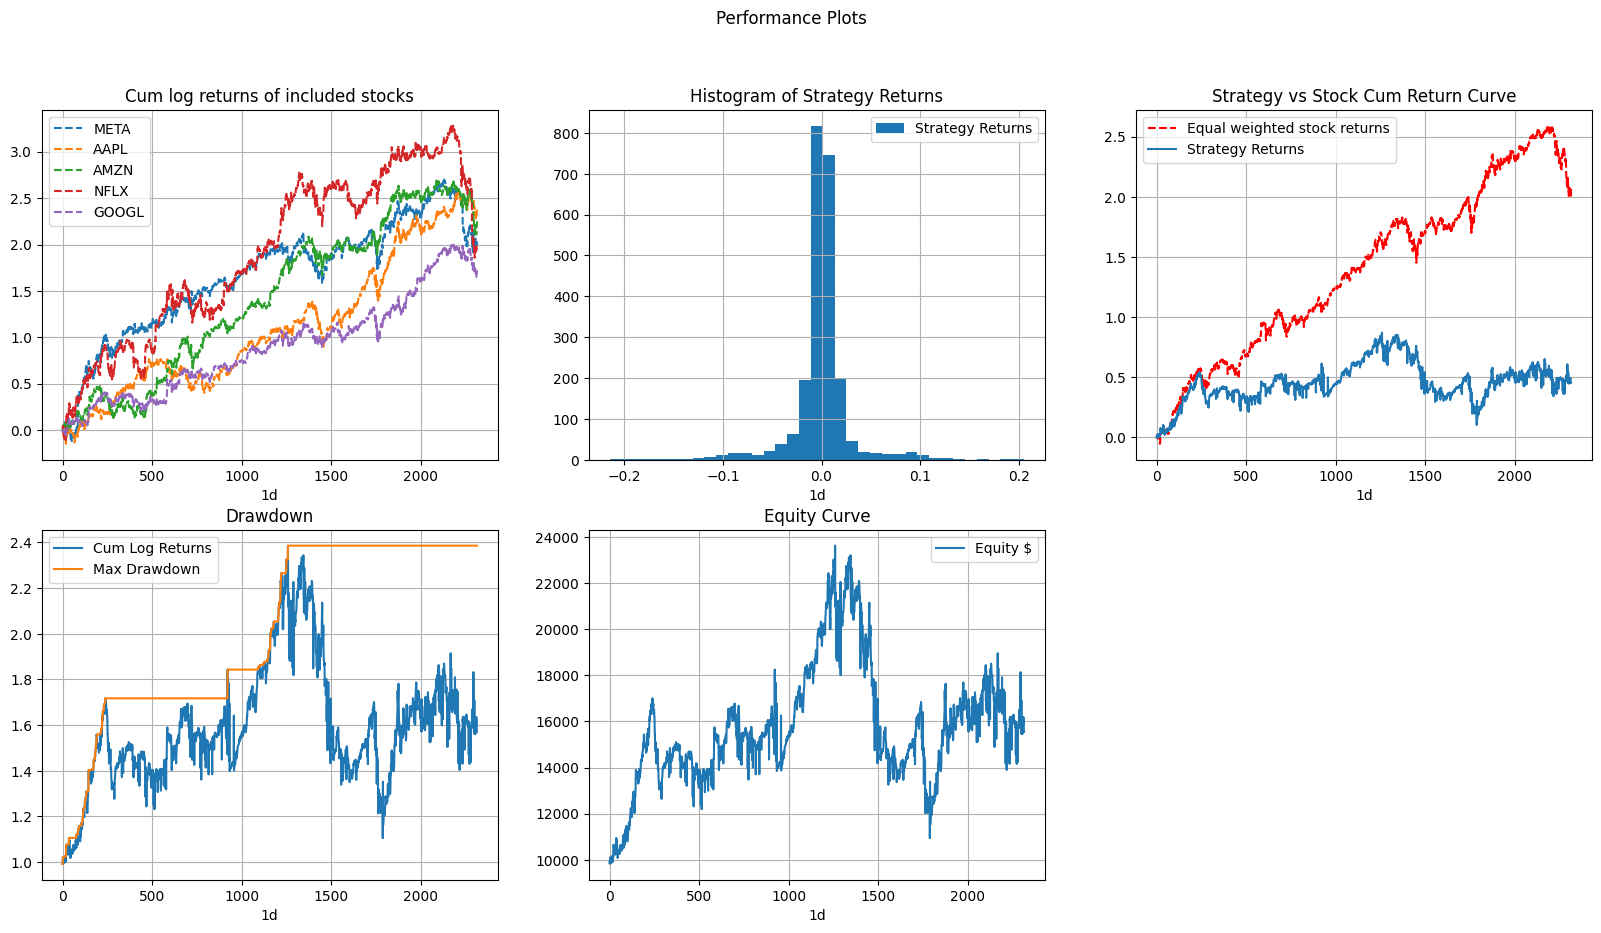

In [6]:
class MA_Strategy(Common_Class):

  def go_long(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == -1:
      self.position['{}'.format(stock)] = 0
      self.buy_order(bar, stock, quantity = -self.quantity['{}'.format(stock)]) # close previous short
    if quantity:
      self.buy_order(bar, stock, quantity = quantity) # open new long
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == 1:
      self.position['{}'.format(stock)] = 0
      self.sell_order(bar, stock, quantity = self.quantity['{}'.format(stock)]) # close previous long
    if quantity:
      self.sell_order(bar, stock, quantity = quantity) # open new short
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.sell_order(bar, stock, dollar = dollar)


  def run_strategy(self, STMA_window, LTMA_window):
    self.trades = 0 # accumulative across all stocks

    for i in self.symbol:
      self.capital = self.initial_capital # reset starting capital when start new stock
      indicator_1 = SMAIndicator(close = self.all_data[i]["Close_Price"], window = STMA_window, fillna=False)
      STMA = indicator_1.sma_indicator()
      indicator_2 = SMAIndicator(close = self.all_data[i]["Close_Price"], window = LTMA_window, fillna=False)
      LTMA = indicator_2.sma_indicator()
      self.all_data[i]["STMA"] = STMA
      self.all_data[i]["LTMA"] = LTMA

      for bar in range(LTMA_window, len(self.all_data[i])):
        date, price = self.return_date_price(bar, i)

        if self.position[i] in [0,-1]:
          if self.all_data[i]["STMA"].iloc[bar]>self.all_data[i]["LTMA"].iloc[bar]:
            self.go_long(bar, i, dollar='all')
            print("----------")
            continue #results already stored in buy_order

        if self.position[i] in [0,1]:
          if self.all_data[i]["STMA"].iloc[bar]<self.all_data[i]["LTMA"].iloc[bar]:
            self.go_short(bar, i, dollar='all')
            print("----------")
            continue

        # store results here if no trade
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(i)], price, i, self.quantity['{}'.format(i)], tb)

      self.last_trade(bar, i)


if __name__ == "__main__":
  A = MA_Strategy(["META", "AAPL", "AMZN", "NFLX", "GOOGL"], "2012-06-01", "2022-06-01","1d", 10000, 0.01, verbose = True)
  A.run_strategy(5,200)
  A.performance()
  A.performance_plots()
